python3 -m venv digs30009

source digs30009/bin/activate

#python3 -m pip install

pip3 install ipykernel

python3 -m ipykernel install --user --name=digs30009_kernel

In [ ]:
#%pip install scikit-learn pandas numpy matplotlib seaborn
#%pip install langchain-community

In [2]:
import os
import glob
import pandas as pd
import numpy as np
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# For text splitting
from langchain_text_splitters import RecursiveCharacterTextSplitter

# For machine learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [4]:
# Set random seed for reproducibility
np.random.seed(60)

In [ ]:
# ## 2. Configuration

# Define folder structure
# Modify these paths to match actual folder structure
DATA_DIR = "/Users/clioluo/Desktop/Fall 2025/DIGS 30009/Final Project/宋明"  # Main directory containing genre folders
GENRES = ["心", "理", "宋明史"]  # Folder names (these become labels)

# Text splitting configuration
CHUNK_SIZE = 30 # Number of characters per chunk
CHUNK_OVERLAP = 0

# Train-test split ratio
TEST_SIZE = 0.2

In [8]:
# ## 3. Initialize Text Splitter
text_splitter = RecursiveCharacterTextSplitter(
    separators=[
        "\n\n",
        "\n",
        " ",
        ".",
        ",",
        "\u200b",  # Zero-width space
        "\uff0c",  # Fullwidth comma
        "\u3001",  # Ideographic comma
        "\uff0e",  # Fullwidth full stop
        "\u3002",  # Ideographic full stop
        "\uff1f",  # Fullwidth question mark
        "\uff01",  # Fullwidth exclamation mark
        "\uff1a",  # Fullwidth colon
        "\uff1b",  # Fullwidth semicolon
    ],
    chunk_size=CHUNK_SIZE,
    chunk_overlap=CHUNK_OVERLAP
)

print(f"Text splitter initialized with chunk_size={CHUNK_SIZE}, chunk_overlap={CHUNK_OVERLAP}")

Text splitter initialized with chunk_size=30, chunk_overlap=0


In [9]:
# ## 4. Read and Process Text Files

def read_texts_from_folder(folder_path, label):
    """
    Read all .txt files from a folder and return list of (text, label) tuples
    """
    texts = []
    txt_files = glob.glob(os.path.join(folder_path, "*.txt"))
    
    print(f"\nProcessing {label} folder: {folder_path}")
    print(f"Found {len(txt_files)} text files")
    
    for file_path in txt_files:
        try:
            # Try UTF-8 first, then GB18030 (common for Chinese texts)
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    text = f.read()
            except UnicodeDecodeError:
                with open(file_path, 'r', encoding='gb18030') as f:
                    text = f.read()
            
            # Basic cleaning
            text = text.strip()
            
            if text:  # Only add non-empty texts
                texts.append({
                    'text': text,
                    'label': label,
                    'filename': os.path.basename(file_path)
                })
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
    
    return texts

In [10]:
# Read all texts from all genre folders
all_documents = []

for genre in GENRES:
    folder_path = os.path.join(DATA_DIR, genre)
    if os.path.exists(folder_path):
        genre_docs = read_texts_from_folder(folder_path, genre)
        all_documents.extend(genre_docs)
    else:
        print(f"Warning: Folder {folder_path} does not exist!")

print(f"\n{'='*60}")
print(f"Total documents loaded: {len(all_documents)}")


Processing 心 folder: /Users/clioluo/Desktop/Fall 2025/DIGS 30009/Final Project/宋明/心
Found 8 text files

Processing 理 folder: /Users/clioluo/Desktop/Fall 2025/DIGS 30009/Final Project/宋明/理
Found 8 text files

Processing 宋明史 folder: /Users/clioluo/Desktop/Fall 2025/DIGS 30009/Final Project/宋明/宋明史
Found 4 text files

Total documents loaded: 20


In [11]:
# ## 5. Split Texts into Chunks

def split_documents(documents, text_splitter):
    """
    Split documents into chunks while preserving labels
    """
    chunks = []
    
    for doc in documents:
        # Split the text
        text_chunks = text_splitter.split_text(doc['text'])
        
        # Create chunk records with labels
        for i, chunk in enumerate(text_chunks):
            chunks.append({
                'text': chunk,
                'label': doc['label'],
                'source_file': doc['filename'],
                'chunk_id': i
            })
    
    return chunks

In [12]:
# Split all documents
print("\nSplitting documents into chunks...")
chunks = split_documents(all_documents, text_splitter)

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(chunks)

print(f"Total chunks created: {len(df)}")
print(f"\nChunks per genre:")
print(df['label'].value_counts())


Splitting documents into chunks...
Total chunks created: 625468

Chunks per genre:
label
宋明史    439378
理      121118
心       64972
Name: count, dtype: int64


In [13]:
# ## 6. Export Labeled Chunks to CSV

# Create output filename with timestamp
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_filename = f"labeled_chunks_{timestamp}.csv"

# Export to CSV
df.to_csv(output_filename, index=False, encoding='utf-8-sig')

print(f"\nLabeled chunks exported to: {output_filename}")
print(f"Total rows exported: {len(df)}")
print(f"Columns: {list(df.columns)}")

# Show first few rows as preview
print("\nPreview of exported data:")
print(df.head(10))


Labeled chunks exported to: labeled_chunks_20251030_215559.csv
Total rows exported: 625468
Columns: ['text', 'label', 'source_file', 'chunk_id']

Preview of exported data:
                            text label source_file  chunk_id
0                 陆九渊集\n卷一\n与邵叔宜     心    陆九渊集.txt         0
1    前日曾尝以夫子所论齐景公、伯夷、齐叔之说，断命以祛俗惑     心    陆九渊集.txt         1
2   ，至今叹服，不能弥忘。为……允其所见，推其所为，勿怠勿画     心    陆九渊集.txt         2
3    ，益著益察，日跻于纯一之地是所望于君子，夷齐未足言也。     心    陆九渊集.txt         3
4            此天所以予我者，非由外烁我也。思则得之     心    陆九渊集.txt         4
5  ，得此也；先立乎其大者，立此者也；积善者，积此者也；集义者     心    陆九渊集.txt         5
6   ，集此者也；知德者知此者也。同此之谓同德，异此之谓异端。     心    陆九渊集.txt         6
7     心逸日休，心劳日拙，德伪之辨也。岂唯辨诸其身人之贤否     心    陆九渊集.txt         7
8                 ，书之正伪，举将不逃于此矣。     心    陆九渊集.txt         8
9  自有诸己至于大而化之，其宽裕温柔足以有容，发强刚毅足以有执     心    陆九渊集.txt         9


In [14]:
# ## 7. Data Exploration and Descriptive Statistics

print("\n" + "="*60)
print("DESCRIPTIVE STATISTICS")
print("="*60)

# 1. Number of observations
print(f"\n1) Number of Observations: {len(df)}")
print(f"   Target Variable (label): Yes, labeled with {df['label'].nunique()} classes")
print(f"   Classes: {list(df['label'].unique())}")

# Class distribution
print("\n   Class Distribution:")
class_dist = df['label'].value_counts()
for label, count in class_dist.items():
    percentage = (count / len(df)) * 100
    print(f"   - {label}: {count} ({percentage:.1f}%)")

# 2. Text length statistics
df['text_length'] = df['text'].apply(len)

print("\n2) Text Length Statistics by Genre:")
length_stats = df.groupby('label')['text_length'].describe()
print(length_stats)

# 3. Unique source files
print("\n3) Source Files:")
print(f"   Total unique source files: {df['source_file'].nunique()}")
for genre in GENRES:
    genre_files = df[df['label'] == genre]['source_file'].nunique()
    print(f"   - {genre}: {genre_files} files")




DESCRIPTIVE STATISTICS

1) Number of Observations: 625468
   Target Variable (label): Yes, labeled with 3 classes
   Classes: ['心', '理', '宋明史']

   Class Distribution:
   - 宋明史: 439378 (70.2%)
   - 理: 121118 (19.4%)
   - 心: 64972 (10.4%)

2) Text Length Statistics by Genre:
          count       mean        std  min   25%   50%   75%     max
label                                                               
宋明史    439378.0  21.912756   6.943820  1.0  18.0  23.0  27.0   977.0
心       64972.0  25.353214  35.231684  1.0  18.0  24.0  27.0  2392.0
理      121118.0  23.830405  32.083608  1.0  17.0  23.0  27.0  2806.0

3) Source Files:
   Total unique source files: 20
   - 心: 8 files
   - 理: 8 files
   - 宋明史: 4 files


In [15]:
# ## 8. Visualizations
from matplotlib.font_manager import FontManager
import matplotlib.pyplot as plt

fm = FontManager()
# Find all fonts that might support Chinese
chinese_fonts = [f.name for f in fm.ttflist if any(keyword in f.name.lower() for keyword in 
                 ['chinese', 'cjk', 'hei', 'song', 'ming', 'kai', 'yuan', 'simsun', 'simhei', 'microsoft', 'noto'])]

print("Available Chinese fonts:")
for font in set(chinese_fonts):
    print(f"  - {font}")


Matplotlib is building the font cache; this may take a moment.


Available Chinese fonts:
  - Noto Sans Linear B
  - Noto Sans Syloti Nagri
  - Noto Sans Khojki
  - Noto Sans Tagbanwa
  - Noto Sans Elbasan
  - Kailasa
  - Noto Sans Old Permic
  - Heiti TC
  - Noto Sans Marchen
  - Noto Sans Gothic
  - Noto Sans Caucasian Albanian
  - Noto Sans Old Persian
  - Noto Sans Coptic
  - Noto Sans Wancho
  - Noto Serif Kannada
  - Noto Sans Gunjala Gondi
  - Noto Sans Batak
  - Noto Sans Adlam
  - Noto Sans Bamum
  - Noto Sans Sharada
  - Noto Sans Phoenician
  - Noto Sans Meroitic
  - Noto Sans Kharoshthi
  - SimSong
  - Kaiti SC
  - Noto Sans Glagolitic
  - Noto Sans Buginese
  - Noto Sans Hanifi Rohingya
  - Noto Sans Duployan
  - Noto Sans Osmanya
  - Noto Sans Lydian
  - Noto Sans Cham
  - Noto Sans Limbu
  - Noto Sans Old Italic
  - Noto Sans Kayah Li
  - Noto Sans Tagalog
  - Noto Sans New Tai Lue
  - Noto Sans Tifinagh
  - Noto Sans Old South Arabian
  - Noto Sans Armenian
  - Noto Sans Ol Chiki
  - Noto Sans Carian
  - LiHei Pro
  - Yuanti SC
  - N

In [16]:
# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(15, 10))
plt.rcParams['font.sans-serif'] = ['Kaiti SC']
plt.rcParams['axes.unicode_minus'] = False

<Figure size 1500x1000 with 0 Axes>

(array([0, 1, 2]), [Text(0, 0, '宋明史'), Text(1, 0, '理'), Text(2, 0, '心')])

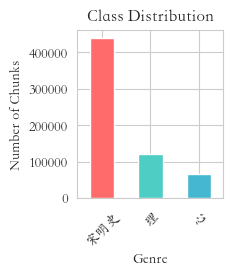

In [17]:
# Plot 1: Class distribution
plt.subplot(2, 3, 1)
df['label'].value_counts().plot(kind='bar', color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
plt.title('Class Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Genre')
plt.ylabel('Number of Chunks')
plt.xticks(rotation=45)

Text(0, 0.5, 'Text Length (characters)')

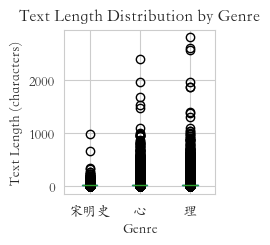

In [ ]:
# Plot 2: Text length distribution
plt.subplot(2, 3, 2)
df.boxplot(column='text_length', by='label', ax=plt.gca())
plt.title('Text Length Distribution by Genre', fontsize=12, fontweight='bold')
plt.suptitle('')
plt.xlabel('Genre')
plt.ylabel('Text Length (characters)')

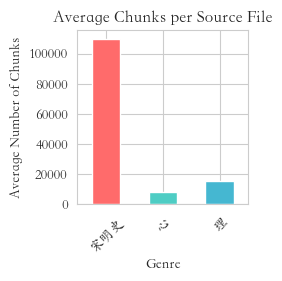

In [ ]:
# Plot 3: Chunks per source file
plt.subplot(2, 3, 4)
chunks_per_file = df.groupby(['label', 'source_file']).size().reset_index(name='chunks')
chunks_summary = chunks_per_file.groupby('label')['chunks'].mean()
chunks_summary.plot(kind='bar', color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
plt.title('Average Chunks per Source File', fontsize=12, fontweight='bold')
plt.xlabel('Genre')
plt.ylabel('Average Number of Chunks')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



In [21]:
# ## 9. Prepare Data for Machine Learning

# Separate features and labels
X = df['text'].values
y = df['label'].values

print("\n" + "="*60)
print("MACHINE LEARNING PREPARATION")
print("="*60)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE, 
    random_state=42, 
    stratify=y  # Maintain class distribution
)

print(f"\nTrain-Test Split:")
print(f"Training set: {len(X_train)} samples ({(1-TEST_SIZE)*100:.0f}%)")
print(f"Test set: {len(X_test)} samples ({TEST_SIZE*100:.0f}%)")

print(f"\nTraining set class distribution:")
train_dist = pd.Series(y_train).value_counts()
for label, count in train_dist.items():
    print(f"  - {label}: {count}")

print(f"\nTest set class distribution:")
test_dist = pd.Series(y_test).value_counts()
for label, count in test_dist.items():
    print(f"  - {label}: {count}")




MACHINE LEARNING PREPARATION

Train-Test Split:
Training set: 500374 samples (80%)
Test set: 125094 samples (20%)

Training set class distribution:
  - 宋明史: 351502
  - 理: 96894
  - 心: 51978

Test set class distribution:
  - 宋明史: 87876
  - 理: 24224
  - 心: 12994


In [22]:
# ## 10. Export Train and Test Sets to CSV
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create DataFrames for train and test sets
train_df = pd.DataFrame({
    'text': X_train,
    'label': y_train
})

test_df = pd.DataFrame({
    'text': X_test,
    'label': y_test
})

# Export to separate CSV files
train_filename = f"train_set_{timestamp}.csv"
test_filename = f"test_set_{timestamp}.csv"

train_df.to_csv(train_filename, index=False, encoding='utf-8-sig')
test_df.to_csv(test_filename, index=False, encoding='utf-8-sig')

print(f"\n{'='*60}")
print("TRAIN-TEST DATA EXPORTED")
print(f"{'='*60}")
print(f"\nTraining set exported to: {train_filename}")
print(f"  - Rows: {len(train_df)}")
print(f"  - Columns: {list(train_df.columns)}")

print(f"\nTest set exported to: {test_filename}")
print(f"  - Rows: {len(test_df)}")
print(f"  - Columns: {list(test_df.columns)}")

print("\nPreview of training data:")
print(train_df.head())

print("\nPreview of test data:")
print(test_df.head())


TRAIN-TEST DATA EXPORTED

Training set exported to: train_set_20251030_215644.csv
  - Rows: 500374
  - Columns: ['text', 'label']

Test set exported to: test_set_20251030_215644.csv
  - Rows: 125094
  - Columns: ['text', 'label']

Preview of training data:
                           text label
0              福州四砦辜岭、甘蔗、五县、水口。   宋明史
1  ，以其通乎性也。故反身修德，斯为学之要。”而其言性之善也     心
2          ，是太王不及泰伯。盖天下有万世不易之常理     理
3   ，谬事之始终，杂施而不逊，是谓异端，是谓邪说，非以致明     心
4  ，日为月掩，则日食。然圣人不言月蚀日，而以「有食」为文者     理

Preview of test data:
                                                text label
0                       ，然后可立贫富之命；穷通不贰，然后可立贵贱之命；夭寿不贰     心
1  \n　　惟公气和而节刚言讷而行敏视之退然初若不能及其当可言之地论议切直风采凛凛中外耸然岂非庶...     理
2                           ，以西为上。礼直官引司徒出诣馔所，与荐俎斋郎奉俎   宋明史
3                                       ，子弟臣僚班爵有差。己卯   宋明史
4                               ，实以盎齐。壶尊次之，实以醍齐，山罍为下   宋明史


In [23]:
# ## 11. Feature Extraction with TF-IDF

print("\nExtracting TF-IDF features...")

# Initialize TF-IDF vectorizer
# For Chinese text, we use character-level n-grams
vectorizer = TfidfVectorizer(
    analyzer='char',  # Character-level analysis for Chinese
    ngram_range=(1, 3),  # Unigrams, bigrams, and trigrams
    max_features=5000,  # Limit features to prevent overfitting
    min_df=2,  # Ignore terms that appear in fewer than 2 documents
    max_df=0.8  # Ignore terms that appear in more than 80% of documents
)

# Fit and transform training data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"\n2) Features:")
print(f"   Number of features: {X_train_tfidf.shape[1]}")
print(f"   Feature type: TF-IDF character n-grams (1-3 grams)")
print(f"   Training matrix shape: {X_train_tfidf.shape}")
print(f"   Test matrix shape: {X_test_tfidf.shape}")
print(f"\n   Scaling issues anticipated: YES")
print(f"   - High dimensionality: {X_train_tfidf.shape[1]} features")
print(f"   - Sparse matrix: {(1 - X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1]))*100:.2f}% sparse")
print(f"   - TF-IDF normalization applied to handle frequency differences")




Extracting TF-IDF features...

2) Features:
   Number of features: 5000
   Feature type: TF-IDF character n-grams (1-3 grams)
   Training matrix shape: (500374, 5000)
   Test matrix shape: (125094, 5000)

   Scaling issues anticipated: YES
   - High dimensionality: 5000 features
   - Sparse matrix: 99.50% sparse
   - TF-IDF normalization applied to handle frequency differences


In [24]:
# ## 12. Model Training and Evaluation

print("\n" + "="*60)
print("MODEL TRAINING AND EVALUATION")
print("="*60)

print("\n3) Supervised Learning Approach: YES")
print("   - We have labeled data (genre categories)")
print("   - Goal is to predict genre of new text chunks")
print("   - Multi-class classification problem")

print("\n4) Five Alternative Models:")

# Dictionary to store models and results
models = {}
results = {}




MODEL TRAINING AND EVALUATION

3) Supervised Learning Approach: YES
   - We have labeled data (genre categories)
   - Goal is to predict genre of new text chunks
   - Multi-class classification problem

4) Five Alternative Models:


In [25]:
# Model 1: Naive Bayes
print("\n   Model 1: Multinomial Naive Bayes")
print("   - Probabilistic classifier based on Bayes' theorem")
print("   - Assumes feature independence")
print("   - Fast and efficient for text classification")

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)
accuracy_nb = accuracy_score(y_test, y_pred_nb)

models['Naive Bayes'] = nb_model
results['Naive Bayes'] = accuracy_nb

print(f"   Accuracy: {accuracy_nb:.4f}")




   Model 1: Multinomial Naive Bayes
   - Probabilistic classifier based on Bayes' theorem
   - Assumes feature independence
   - Fast and efficient for text classification
   Accuracy: 0.8909


In [26]:
# Model 2: K-Nearest Neighbors
print("\n   Model 2: K-Nearest Neighbors (KNN)")
print("   - Instance-based learning (lazy learner)")
print("   - Classifies based on majority vote of k nearest neighbors")
print("   - Non-parametric, good for complex decision boundaries")

knn_model = KNeighborsClassifier(n_neighbors=5, metric='cosine', n_jobs=-1)
knn_model.fit(X_train_tfidf, y_train)
y_pred_knn = knn_model.predict(X_test_tfidf)
accuracy_knn = accuracy_score(y_test, y_pred_knn)

models['KNN'] = knn_model
results['KNN'] = accuracy_knn

print(f"   Accuracy: {accuracy_knn:.4f}")


   Model 2: K-Nearest Neighbors (KNN)
   - Instance-based learning (lazy learner)
   - Classifies based on majority vote of k nearest neighbors
   - Non-parametric, good for complex decision boundaries
   Accuracy: 0.8762


In [27]:
# Model 3: Random Forest
print("\n   Model 3: Random Forest Classifier")
print("   - Ensemble of decision trees")
print("   - Handles non-linear relationships")
print("   - Provides feature importance")

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

models['Random Forest'] = rf_model
results['Random Forest'] = accuracy_rf

print(f"   Accuracy: {accuracy_rf:.4f}")




   Model 3: Random Forest Classifier
   - Ensemble of decision trees
   - Handles non-linear relationships
   - Provides feature importance
   Accuracy: 0.9004


In [28]:
# Model 4: Linear Support Vector Machine
from sklearn.svm import SVC


print("\n   Model 4: Linear Support Vector Machine")
print("   - Finds optimal hyperplane for classification")
print("   - Effective in high-dimensional spaces")
print("   - Good for text classification")

svm_model = LinearSVC(random_state=42, max_iter=2000)
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)
accuracy_svm = accuracy_score(y_test, y_pred_svm)

models['Linear SVM'] = svm_model
results['Linear SVM'] = accuracy_svm

print(f"   Accuracy: {accuracy_svm:.4f}")


   Model 4: Linear Support Vector Machine
   - Finds optimal hyperplane for classification
   - Effective in high-dimensional spaces
   - Good for text classification
   Accuracy: 0.9196


In [29]:
# Model 5: Non-linear SVM
print("\n   Model 5: Non-Linear Support Vector Machine (RBF Kernel)")
print("   - Uses RBF kernel to handle non-linear decision boundaries")

svm_rbf_model = SVC(kernel='rbf', random_state=42, max_iter=5000, tol=1e-3)
svm_rbf_model.fit(X_train_tfidf, y_train)
y_pred_svm_rbf = svm_rbf_model.predict(X_test_tfidf)
accuracy_svm_rbf = accuracy_score(y_test, y_pred_svm_rbf)

models['Non-Linear SVM'] = svm_rbf_model
results['Non-Linear SVM'] = accuracy_svm_rbf

print(f"   Accuracy: {accuracy_svm_rbf:.4f}")


   Model 5: Non-Linear Support Vector Machine (RBF Kernel)
   - Uses RBF kernel to handle non-linear decision boundaries


/Users/clioluo/Desktop/Fall 2025/DIGS 30009/digs30009/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


   Accuracy: 0.8618


In [ ]:
# ## 13. Detailed Results and Comparison

print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': list(results.values())
}).sort_values('Accuracy', ascending=False)

print("\n" + comparison_df.to_string(index=False))

# The accuracy score is calculate in this way:
# from sklearn.metrics import accuracy_score
# accuracy_rf = accuracy_score(y_test, y_pred_rf)
# They used the accuracy_score function from sklearn.metrics, which compares the true labels (y_test) with the predicted labels (y_pred_rf) and calculates the proportion of correct predictions.


MODEL COMPARISON

         Model  Accuracy
    Linear SVM  0.919580
 Random Forest  0.900411
   Naive Bayes  0.890866
           KNN  0.876197
Non-Linear SVM  0.861752


In [31]:
# Best model
best_model_name = comparison_df.iloc[0]['Model']
best_model = models[best_model_name]

print(f"\nBest Model: {best_model_name}")
print(f"Accuracy: {comparison_df.iloc[0]['Accuracy']:.4f}")




Best Model: Linear SVM
Accuracy: 0.9196


In [32]:
# Detailed classification report for best model
if best_model_name == 'Naive Bayes':
    y_pred_best = y_pred_nb
elif best_model_name == 'KNN':
    y_pred_best = y_pred_knn
elif best_model_name == 'Random Forest':
    y_pred_best = y_pred_rf
elif best_model_name == 'Linear SVM':
    y_pred_best = y_pred_svm
elif best_model_name == 'Non-Linear SVM':
    y_pred_best = y_pred_svm_rbf
else:
    y_pred_best = y_pred_svm

print(f"\nDetailed Classification Report ({best_model_name}):")
print(classification_report(y_test, y_pred_best))




Detailed Classification Report (Linear SVM):
              precision    recall  f1-score   support

         宋明史       0.95      0.98      0.97     87876
           心       0.79      0.66      0.72     12994
           理       0.86      0.84      0.85     24224

    accuracy                           0.92    125094
   macro avg       0.87      0.83      0.84    125094
weighted avg       0.92      0.92      0.92    125094



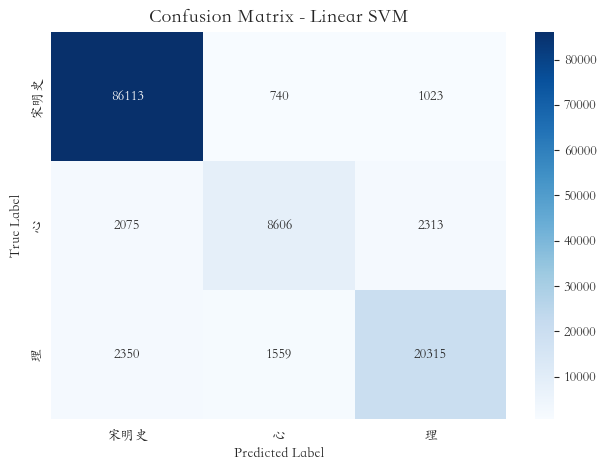

In [33]:
# Confusion Matrix
labels = sorted(set(y_test))  # Get actual labels from data in consistent order
cm = confusion_matrix(y_test, y_pred_best, labels=labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


In [34]:
# ## 14. Anticipated Problems

print("\n" + "="*60)
print("5) ANTICIPATED PROBLEMS")
print("="*60)

print("""
Data Issues:
  - Class Imbalance: Unequal distribution across genres may bias model
  - Text Length Variation: Poetry chunks may be systematically shorter
  - Limited Data: Small dataset increases overfitting risk
  - Data Leakage: Multiple chunks from same source file may be too similar

Linguistic Challenges:
  - No Word Boundaries: Classical Chinese has no spaces between words
  - Character Ambiguity: Same characters have different meanings in context
  - Language Evolution: Song-Ming vs Pre-Qin language patterns differ
  - Genre Mixing: Some texts blend multiple genres

Technical Challenges:
  - High Dimensionality: Large feature space with limited samples
  - Sparse Features: Most character n-grams appear rarely
  - Overfitting: Models may memorize training patterns
  - Cross-validation: Small dataset makes validation unstable

Methodological Concerns:
  - Temporal Mismatch: Training and test data from different time periods
  - Chunking Artifacts: Arbitrary splits may break semantic units
  - Feature Selection: Need to balance informativeness vs. generalization
""")




5) ANTICIPATED PROBLEMS

Data Issues:
  - Class Imbalance: Unequal distribution across genres may bias model
  - Text Length Variation: Poetry chunks may be systematically shorter
  - Limited Data: Small dataset increases overfitting risk
  - Data Leakage: Multiple chunks from same source file may be too similar

Linguistic Challenges:
  - No Word Boundaries: Classical Chinese has no spaces between words
  - Character Ambiguity: Same characters have different meanings in context
  - Language Evolution: Song-Ming vs Pre-Qin language patterns differ
  - Genre Mixing: Some texts blend multiple genres

Technical Challenges:
  - High Dimensionality: Large feature space with limited samples
  - Sparse Features: Most character n-grams appear rarely
  - Overfitting: Models may memorize training patterns
  - Cross-validation: Small dataset makes validation unstable

Methodological Concerns:
  - Temporal Mismatch: Training and test data from different time periods
  - Chunking Artifacts: Arbitr

In [35]:
# ## 15. Summary Statistics for Report

print("\n" + "="*60)
print("SUMMARY FOR REPORT")
print("="*60)

summary = {
    'Total Observations': len(df),
    'Number of Classes': df['label'].nunique(),
    'Class Labels': ', '.join(df['label'].unique()),
    'Number of Features': X_train_tfidf.shape[1],
    'Training Samples': len(X_train),
    'Test Samples': len(X_test),
    'Best Model': best_model_name,
    'Best Accuracy': f"{comparison_df.iloc[0]['Accuracy']:.4f}",
    'Average Chunk Length': f"{df['text_length'].mean():.1f} characters",
    'Source Files': df['source_file'].nunique()
}

for key, value in summary.items():
    print(f"{key}: {value}")

print("\n" + "="*60)
print("Analysis complete!")
print("="*60)



SUMMARY FOR REPORT
Total Observations: 625468
Number of Classes: 3
Class Labels: 心, 理, 宋明史
Number of Features: 5000
Training Samples: 500374
Test Samples: 125094
Best Model: Linear SVM
Best Accuracy: 0.9196
Average Chunk Length: 22.6 characters
Source Files: 20

Analysis complete!


In [36]:
# ## 16. Using the Model to Categorize New Documents

print("\n" + "="*60)
print("CATEGORIZING NEW DOCUMENTS")
print("="*60)

def categorize_new_document(file_path, model, vectorizer, text_splitter):
    """
    Categorize a new document using the trained model
    
    Args:
        file_path: Path to the new text file
        model: Trained classifier model
        vectorizer: Fitted TF-IDF vectorizer
        text_splitter: Text splitter instance
    
    Returns:
        Dictionary with predictions and statistics
    """
    try:
        # Read the file
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                text = f.read()
        except UnicodeDecodeError:
            with open(file_path, 'r', encoding='gb18030') as f:
                text = f.read()
        
        # Clean and split the text
        text = text.strip()
        chunks = text_splitter.split_text(text)
        
        if not chunks:
            return {"error": "No text found in document"}
        
        # Transform chunks using the fitted vectorizer
        chunks_tfidf = vectorizer.transform(chunks)
        
        # Make predictions
        predictions = model.predict(chunks_tfidf)
        
        # Get prediction probabilities (if model supports it)
        if hasattr(model, 'predict_proba'):
            probabilities = model.predict_proba(chunks_tfidf)
            confidence_scores = [max(prob) for prob in probabilities]
        else:
            confidence_scores = [1.0] * len(predictions)  # SVM doesn't have predict_proba
        
        # Aggregate results
        from collections import Counter
        prediction_counts = Counter(predictions)
        total_chunks = len(predictions)
        
        # Determine overall category (majority vote)
        overall_category = prediction_counts.most_common(1)[0][0]
        
        # Calculate average confidence
        avg_confidence = np.mean(confidence_scores)
        
        results = {
            "file": os.path.basename(file_path),
            "total_chunks": total_chunks,
            "overall_category": overall_category,
            "average_confidence": avg_confidence,
            "category_breakdown": dict(prediction_counts),
            "category_percentages": {cat: (count/total_chunks)*100 
                                    for cat, count in prediction_counts.items()},
            "chunk_predictions": list(zip(chunks, predictions, confidence_scores))
        }
        
        return results
        
    except Exception as e:
        return {"error": str(e)}


def categorize_folder(folder_path, model, vectorizer, text_splitter):
    """
    Categorize all text files in a folder
    
    Args:
        folder_path: Path to folder containing text files
        model: Trained classifier model
        vectorizer: Fitted TF-IDF vectorizer
        text_splitter: Text splitter instance
    
    Returns:
        List of results for each file
    """
    results = []
    txt_files = glob.glob(os.path.join(folder_path, "*.txt"))
    
    print(f"\nProcessing {len(txt_files)} files from {folder_path}")
    
    for file_path in txt_files:
        result = categorize_new_document(file_path, model, vectorizer, text_splitter)
        results.append(result)
        
        # Print summary
        if "error" not in result:
            print(f"\n{result['file']}:")
            print(f"  Category: {result['overall_category']}")
            print(f"  Confidence: {result['average_confidence']:.2%}")
            print(f"  Breakdown: {result['category_percentages']}")
        else:
            print(f"\n{file_path}: ERROR - {result['error']}")
    
    return results


# Example usage with the best model
print("\n--- Example: How to Categorize New Documents ---\n")
print("# Categorize a single new document:")
print("results = categorize_new_document('path/to/new_document.txt', best_model, vectorizer, text_splitter)")
print("print(results['overall_category'])")
print("print(results['category_percentages'])")

print("\n# Categorize all documents in a folder:")
print("results = categorize_folder('path/to/new_documents/', best_model, vectorizer, text_splitter)")

print("\n# Export predictions to CSV:")
print("predictions_df = pd.DataFrame(results)")
print("predictions_df.to_csv('predictions.csv', index=False, encoding='utf-8-sig')")

# Uncomment and modify these lines to categorize your own documents:
# 
# # Single file
# new_doc_results = categorize_new_document(
#     'path/to/your/new_document.txt', 
#     best_model, 
#     vectorizer, 
#     text_splitter
# )
# print(f"\nPredicted category: {new_doc_results['overall_category']}")
# print(f"Confidence: {new_doc_results['average_confidence']:.2%}")
# 
# # Entire folder
# folder_results = categorize_folder(
#     'path/to/your/new_documents/', 
#     best_model, 
#     vectorizer, 
#     text_splitter
# )
# 
# # Save results
# results_df = pd.DataFrame(folder_results)
# results_df.to_csv('new_document_predictions.csv', index=False, encoding='utf-8-sig')

print("\n" + "="*60)
print("To use this on your own documents:")
print("1. Uncomment the example code above")
print("2. Replace the file/folder paths with your actual paths")
print("3. Run the cell to get predictions")
print("="*60)


CATEGORIZING NEW DOCUMENTS

--- Example: How to Categorize New Documents ---

# Categorize a single new document:
results = categorize_new_document('path/to/new_document.txt', best_model, vectorizer, text_splitter)
print(results['overall_category'])
print(results['category_percentages'])

# Categorize all documents in a folder:
results = categorize_folder('path/to/new_documents/', best_model, vectorizer, text_splitter)

# Export predictions to CSV:
predictions_df = pd.DataFrame(results)
predictions_df.to_csv('predictions.csv', index=False, encoding='utf-8-sig')

To use this on your own documents:
1. Uncomment the example code above
2. Replace the file/folder paths with your actual paths
3. Run the cell to get predictions
